<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W3/ungraded_labs/C4_W3_Lab_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [6]:
#!pip install tensorflow==2.5.0

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


## 构造数据

In [8]:
def plot_history(history, start_epoch=None, end_epoch=None):
    if start_epoch is None:
        start_epoch = 0
    if end_epoch is None:
        end_epoch = len(history.history['loss'])       
            
    max_epoch = min(len(history.history['loss']), end_epoch)
    loss = history.history['loss'][start_epoch:end_epoch]
    val_loss = history.history['val_loss'][start_epoch:end_epoch]
    
    plt.figure(figsize=(8, 5))
    epochs = range(start_epoch, max_epoch)
    if max_epoch <= 20:
        xticks = range(start_epoch, max_epoch)
    else:
        xticks = range(start_epoch, max_epoch, (max_epoch-1)//20+10)

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

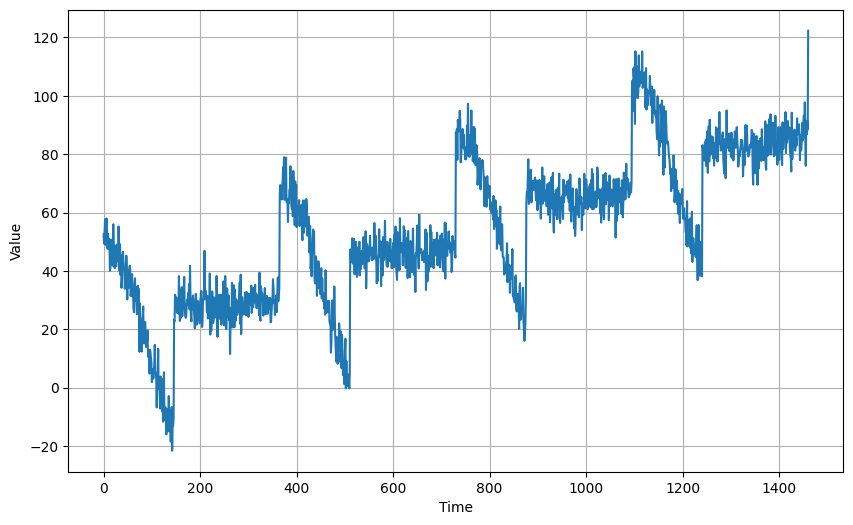

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Simple RNN

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, validation_data=val_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 58ms/step - loss: 144.8158 - mae: 145.3158 - val_loss: 185.9893 - val_mae: 186.4893 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 43ms/step - loss: 142.1432 - mae: 142.6432 - val_loss: 182.9465 - val_mae: 183.4465 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 43ms/step - loss: 138.9059 - mae: 139.4059 - val_loss: 179.4947 - val_mae: 179.9947 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 45ms/step - loss: 135.2632 - mae: 135.7632 - val_loss: 175.6070 - val_mae: 176.1070 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 131.1719 - mae: 131.6719 - val_loss: 171.2264 - val_mae: 171.7264 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 44ms/step - loss: 126.5735 - mae: 127.0733 - val_loss: 166.2700 - val_mae: 166.7700 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 45

Epoch 55/100
31/31 [==============================] - 2s 45ms/step - loss: 6.3668 - mae: 6.8525 - val_loss: 6.8645 - val_mae: 7.3517 - lr: 5.0119e-06
Epoch 56/100
31/31 [==============================] - 2s 46ms/step - loss: 6.3565 - mae: 6.8404 - val_loss: 7.3652 - val_mae: 7.8468 - lr: 5.6234e-06
Epoch 57/100
31/31 [==============================] - 2s 50ms/step - loss: 5.8965 - mae: 6.3773 - val_loss: 6.6920 - val_mae: 7.1784 - lr: 6.3096e-06
Epoch 58/100
31/31 [==============================] - 2s 46ms/step - loss: 5.8947 - mae: 6.3764 - val_loss: 7.0370 - val_mae: 7.5209 - lr: 7.0795e-06
Epoch 59/100
31/31 [==============================] - 1s 44ms/step - loss: 5.7795 - mae: 6.2635 - val_loss: 7.6306 - val_mae: 8.1204 - lr: 7.9433e-06
Epoch 60/100
31/31 [==============================] - 2s 51ms/step - loss: 5.3245 - mae: 5.8038 - val_loss: 7.9205 - val_mae: 8.4105 - lr: 8.9125e-06
Epoch 61/100
31/31 [==============================] - 1s 43ms/step - loss: 6.1436 - mae: 6.6222 - va

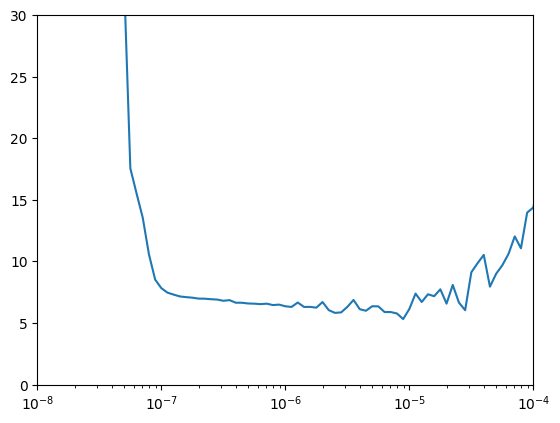

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400, validation_data=val_set)

Epoch 1/400
8/8 [==============================] - 2s 113ms/step - loss: 72.0323 - mae: 72.5316 - val_loss: 57.7941 - val_mae: 58.2941
Epoch 2/400
8/8 [==============================] - 1s 59ms/step - loss: 19.2475 - mae: 19.7415 - val_loss: 13.9963 - val_mae: 14.4918
Epoch 3/400
8/8 [==============================] - 1s 55ms/step - loss: 19.1910 - mae: 19.6874 - val_loss: 48.2208 - val_mae: 48.7208
Epoch 4/400
8/8 [==============================] - 1s 66ms/step - loss: 16.3122 - mae: 16.8063 - val_loss: 41.7270 - val_mae: 42.2270
Epoch 5/400
8/8 [==============================] - 1s 54ms/step - loss: 14.5793 - mae: 15.0715 - val_loss: 26.8614 - val_mae: 27.3590
Epoch 6/400
8/8 [==============================] - 1s 62ms/step - loss: 12.4398 - mae: 12.9311 - val_loss: 29.8364 - val_mae: 30.3364
Epoch 7/400
8/8 [==============================] - 1s 73ms/step - loss: 9.8258 - mae: 10.3162 - val_loss: 11.1077 - val_mae: 11.6031
Epoch 8/400
8/8 [==============================] - 1s 54ms/ste

Epoch 63/400
8/8 [==============================] - 1s 55ms/step - loss: 5.0172 - mae: 5.4927 - val_loss: 7.2261 - val_mae: 7.7046
Epoch 64/400
8/8 [==============================] - 1s 68ms/step - loss: 5.0820 - mae: 5.5602 - val_loss: 8.8889 - val_mae: 9.3797
Epoch 65/400
8/8 [==============================] - 1s 61ms/step - loss: 5.7622 - mae: 6.2449 - val_loss: 6.8080 - val_mae: 7.2844
Epoch 66/400
8/8 [==============================] - 1s 55ms/step - loss: 5.4885 - mae: 5.9664 - val_loss: 7.4523 - val_mae: 7.9356
Epoch 67/400
8/8 [==============================] - 1s 60ms/step - loss: 6.1244 - mae: 6.6091 - val_loss: 9.7609 - val_mae: 10.2476
Epoch 68/400
8/8 [==============================] - 1s 56ms/step - loss: 5.8730 - mae: 6.3538 - val_loss: 13.3047 - val_mae: 13.7987
Epoch 69/400
8/8 [==============================] - 1s 55ms/step - loss: 5.2859 - mae: 5.7646 - val_loss: 7.1681 - val_mae: 7.6563
Epoch 70/400
8/8 [==============================] - 1s 59ms/step - loss: 6.2864 

8/8 [==============================] - 1s 56ms/step - loss: 5.2390 - mae: 5.7174 - val_loss: 8.7438 - val_mae: 9.2261
Epoch 126/400
8/8 [==============================] - 1s 59ms/step - loss: 4.9280 - mae: 5.4090 - val_loss: 6.3358 - val_mae: 6.8238
Epoch 127/400
8/8 [==============================] - 1s 62ms/step - loss: 4.6629 - mae: 5.1382 - val_loss: 9.3193 - val_mae: 9.8100
Epoch 128/400
8/8 [==============================] - 1s 63ms/step - loss: 5.0928 - mae: 5.5699 - val_loss: 7.4396 - val_mae: 7.9204
Epoch 129/400
8/8 [==============================] - 1s 56ms/step - loss: 4.6806 - mae: 5.1597 - val_loss: 6.7821 - val_mae: 7.2585
Epoch 130/400
8/8 [==============================] - 1s 55ms/step - loss: 5.3567 - mae: 5.8356 - val_loss: 6.7428 - val_mae: 7.2263
Epoch 131/400
8/8 [==============================] - 1s 55ms/step - loss: 4.6576 - mae: 5.1322 - val_loss: 6.1321 - val_mae: 6.6131
Epoch 132/400
8/8 [==============================] - 1s 55ms/step - loss: 5.8160 - mae: 6.

Epoch 187/400
8/8 [==============================] - 1s 56ms/step - loss: 4.6937 - mae: 5.1742 - val_loss: 6.6147 - val_mae: 7.1017
Epoch 188/400
8/8 [==============================] - 1s 56ms/step - loss: 5.0165 - mae: 5.4929 - val_loss: 6.6093 - val_mae: 7.0920
Epoch 189/400
8/8 [==============================] - 1s 65ms/step - loss: 4.7823 - mae: 5.2604 - val_loss: 6.3224 - val_mae: 6.8031
Epoch 190/400
8/8 [==============================] - 1s 61ms/step - loss: 5.0707 - mae: 5.5525 - val_loss: 7.9018 - val_mae: 8.3905
Epoch 191/400
8/8 [==============================] - 1s 56ms/step - loss: 4.6686 - mae: 5.1494 - val_loss: 5.9056 - val_mae: 6.3840
Epoch 192/400
8/8 [==============================] - 1s 61ms/step - loss: 4.9565 - mae: 5.4312 - val_loss: 6.6997 - val_mae: 7.1805
Epoch 193/400
8/8 [==============================] - 1s 66ms/step - loss: 6.5385 - mae: 7.0191 - val_loss: 6.8738 - val_mae: 7.3569
Epoch 194/400
8/8 [==============================] - 1s 56ms/step - loss: 7.

8/8 [==============================] - 1s 57ms/step - loss: 4.9454 - mae: 5.4239 - val_loss: 6.7080 - val_mae: 7.1902
Epoch 250/400
8/8 [==============================] - 1s 55ms/step - loss: 5.7981 - mae: 6.2801 - val_loss: 10.7836 - val_mae: 11.2729
Epoch 251/400
8/8 [==============================] - 1s 55ms/step - loss: 4.9135 - mae: 5.3908 - val_loss: 8.0518 - val_mae: 8.5403
Epoch 252/400
8/8 [==============================] - 1s 60ms/step - loss: 4.5989 - mae: 5.0771 - val_loss: 7.5697 - val_mae: 8.0523
Epoch 253/400
8/8 [==============================] - 1s 55ms/step - loss: 5.0289 - mae: 5.5086 - val_loss: 6.4924 - val_mae: 6.9767
Epoch 254/400
8/8 [==============================] - 1s 65ms/step - loss: 4.3224 - mae: 4.7969 - val_loss: 6.0901 - val_mae: 6.5718
Epoch 255/400
8/8 [==============================] - 1s 55ms/step - loss: 4.1686 - mae: 4.6396 - val_loss: 6.1284 - val_mae: 6.6129
Epoch 256/400
8/8 [==============================] - 1s 58ms/step - loss: 4.0471 - mae: 

8/8 [==============================] - 1s 68ms/step - loss: 4.1301 - mae: 4.6035 - val_loss: 5.6240 - val_mae: 6.1020
Epoch 312/400
8/8 [==============================] - 1s 57ms/step - loss: 4.6034 - mae: 5.0768 - val_loss: 5.5524 - val_mae: 6.0349
Epoch 313/400
8/8 [==============================] - 1s 58ms/step - loss: 4.8376 - mae: 5.3126 - val_loss: 5.6130 - val_mae: 6.0914
Epoch 314/400
8/8 [==============================] - 1s 60ms/step - loss: 5.8194 - mae: 6.3027 - val_loss: 7.1361 - val_mae: 7.6260
Epoch 315/400
8/8 [==============================] - 1s 56ms/step - loss: 5.3605 - mae: 5.8436 - val_loss: 6.6781 - val_mae: 7.1652
Epoch 316/400
8/8 [==============================] - 1s 57ms/step - loss: 5.0391 - mae: 5.5196 - val_loss: 7.9258 - val_mae: 8.4134
Epoch 317/400
8/8 [==============================] - 1s 57ms/step - loss: 5.2495 - mae: 5.7274 - val_loss: 7.5847 - val_mae: 8.0664
Epoch 318/400
8/8 [==============================] - 1s 55ms/step - loss: 4.5641 - mae: 5.

8/8 [==============================] - 1s 55ms/step - loss: 4.2432 - mae: 4.7202 - val_loss: 6.2277 - val_mae: 6.7143
Epoch 374/400
8/8 [==============================] - 1s 55ms/step - loss: 4.0984 - mae: 4.5713 - val_loss: 6.6703 - val_mae: 7.1519
Epoch 375/400
8/8 [==============================] - 1s 65ms/step - loss: 4.2661 - mae: 4.7397 - val_loss: 5.6793 - val_mae: 6.1567
Epoch 376/400
8/8 [==============================] - 1s 57ms/step - loss: 3.9930 - mae: 4.4670 - val_loss: 5.5968 - val_mae: 6.0747
Epoch 377/400
8/8 [==============================] - 1s 55ms/step - loss: 4.5040 - mae: 4.9816 - val_loss: 6.2952 - val_mae: 6.7788
Epoch 378/400
8/8 [==============================] - 1s 65ms/step - loss: 5.4164 - mae: 5.8989 - val_loss: 6.5248 - val_mae: 7.0092
Epoch 379/400
8/8 [==============================] - 1s 58ms/step - loss: 5.0664 - mae: 5.5426 - val_loss: 10.2819 - val_mae: 10.7785
Epoch 380/400
8/8 [==============================] - 1s 58ms/step - loss: 5.3065 - mae: 

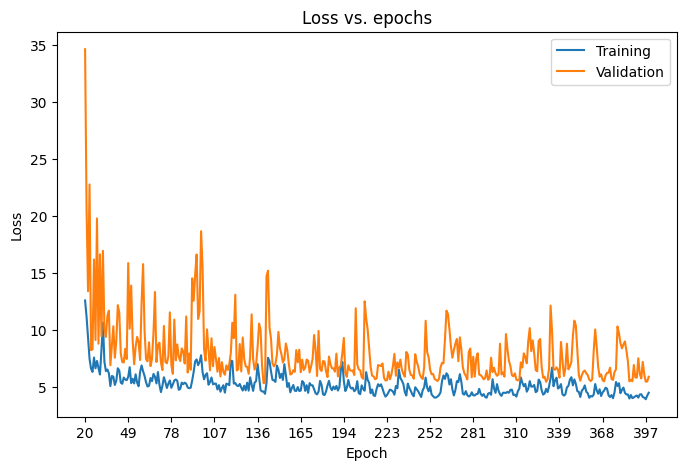

In [15]:
plot_history(history, start_epoch=10)

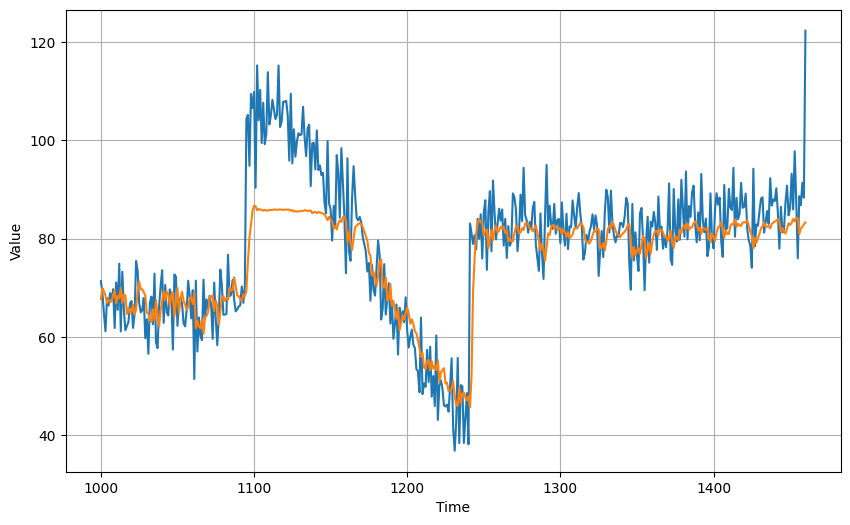

In [16]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [17]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

76.49931
6.2404947


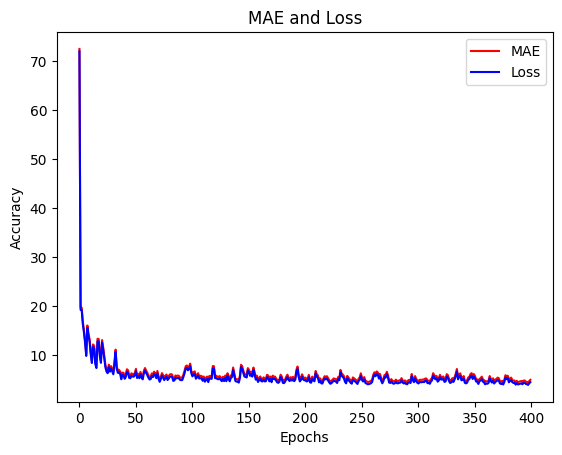

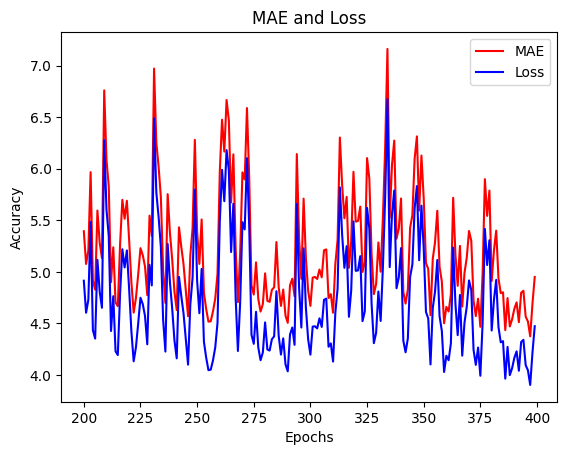

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()
plt.show()

## LSTM

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, validation_data=val_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 8s 66ms/step - loss: 21.5167 - mae: 22.0115 - val_loss: 53.6988 - val_mae: 54.1988 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 21.1522 - mae: 21.6444 - val_loss: 53.0076 - val_mae: 53.5076 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 20.7302 - mae: 21.2236 - val_loss: 52.2550 - val_mae: 52.7550 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 13ms/step - loss: 20.2834 - mae: 20.7757 - val_loss: 51.3936 - val_mae: 51.8936 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 19.7897 - mae: 20.2855 - val_loss: 50.3562 - val_mae: 50.8562 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 19.1782 - mae: 19.6696 - val_loss: 48.9417 - val_mae: 49.4417 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 18.2410 

31/31 [==============================] - 0s 12ms/step - loss: 5.5272 - mae: 6.0025 - val_loss: 10.1010 - val_mae: 10.5912 - lr: 4.4668e-06
Epoch 55/100
31/31 [==============================] - 0s 12ms/step - loss: 5.4025 - mae: 5.8739 - val_loss: 8.0141 - val_mae: 8.5032 - lr: 5.0119e-06
Epoch 56/100
31/31 [==============================] - 0s 12ms/step - loss: 5.5590 - mae: 6.0303 - val_loss: 8.6877 - val_mae: 9.1720 - lr: 5.6234e-06
Epoch 57/100
31/31 [==============================] - 0s 13ms/step - loss: 5.2941 - mae: 5.7721 - val_loss: 7.4016 - val_mae: 7.8852 - lr: 6.3096e-06
Epoch 58/100
31/31 [==============================] - 0s 12ms/step - loss: 5.2838 - mae: 5.7649 - val_loss: 7.2861 - val_mae: 7.7743 - lr: 7.0795e-06
Epoch 59/100
31/31 [==============================] - 0s 13ms/step - loss: 5.1405 - mae: 5.6198 - val_loss: 7.1041 - val_mae: 7.5911 - lr: 7.9433e-06
Epoch 60/100
31/31 [==============================] - 1s 13ms/step - loss: 5.0468 - mae: 5.5191 - val_loss: 6.2

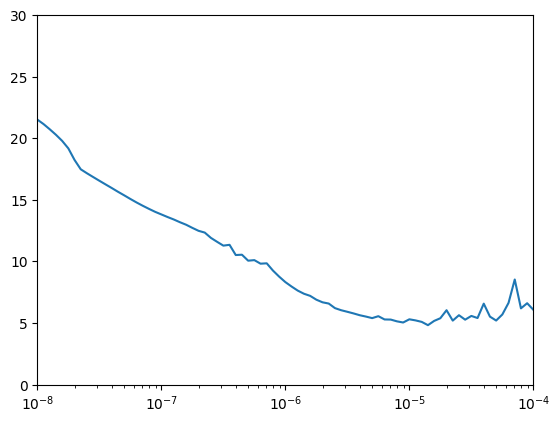

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [27]:
# This code block will take some time to run.
# But it will run in the background, without displaying/printing 
# the information about the number of epochs.


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset, validation_data=val_set, epochs=500)

Epoch 1/500
31/31 [==============================] - 8s 65ms/step - loss: 774.8784 - mae: 21.4006 - val_loss: 314.2688 - val_mae: 14.7366
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 122.2094 - mae: 8.3569 - val_loss: 419.9860 - val_mae: 18.0737
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 120.4912 - mae: 8.6153 - val_loss: 723.2532 - val_mae: 23.9365
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 96.7724 - mae: 7.7211 - val_loss: 142.6744 - val_mae: 9.2614
Epoch 5/500
31/31 [==============================] - 0s 12ms/step - loss: 108.8916 - mae: 8.1784 - val_loss: 606.1452 - val_mae: 21.7040
Epoch 6/500
31/31 [==============================] - 0s 12ms/step - loss: 129.3812 - mae: 9.0531 - val_loss: 336.8270 - val_mae: 15.3587
Epoch 7/500
31/31 [==============================] - 0s 12ms/step - loss: 61.5435 - mae: 5.9218 - val_loss: 78.9044 - val_mae: 6.8563
Epoch 8/500
31/31 [==========================

31/31 [==============================] - 1s 15ms/step - loss: 46.4315 - mae: 5.1491 - val_loss: 125.4008 - val_mae: 8.7996
Epoch 62/500
31/31 [==============================] - 0s 13ms/step - loss: 54.2458 - mae: 5.7132 - val_loss: 128.3125 - val_mae: 8.7140
Epoch 63/500
31/31 [==============================] - 0s 12ms/step - loss: 47.8914 - mae: 5.2416 - val_loss: 161.8413 - val_mae: 10.5515
Epoch 64/500
31/31 [==============================] - 0s 12ms/step - loss: 67.5664 - mae: 6.4471 - val_loss: 128.7990 - val_mae: 8.6868
Epoch 65/500
31/31 [==============================] - 0s 12ms/step - loss: 69.4568 - mae: 6.5835 - val_loss: 116.5446 - val_mae: 8.1779
Epoch 66/500
31/31 [==============================] - 0s 12ms/step - loss: 50.5723 - mae: 5.3720 - val_loss: 76.7509 - val_mae: 6.4587
Epoch 67/500
31/31 [==============================] - 0s 12ms/step - loss: 51.4664 - mae: 5.4227 - val_loss: 95.6130 - val_mae: 7.2756
Epoch 68/500
31/31 [==============================] - 0s 12ms/

31/31 [==============================] - 0s 12ms/step - loss: 42.6327 - mae: 4.9994 - val_loss: 63.3436 - val_mae: 6.2060
Epoch 122/500
31/31 [==============================] - 0s 12ms/step - loss: 65.0267 - mae: 6.2782 - val_loss: 145.0228 - val_mae: 9.2960
Epoch 123/500
31/31 [==============================] - 0s 12ms/step - loss: 49.8960 - mae: 5.3631 - val_loss: 66.6497 - val_mae: 6.3563
Epoch 124/500
31/31 [==============================] - 0s 12ms/step - loss: 50.7631 - mae: 5.4663 - val_loss: 165.9584 - val_mae: 10.4794
Epoch 125/500
31/31 [==============================] - 0s 12ms/step - loss: 48.1408 - mae: 5.3144 - val_loss: 95.9412 - val_mae: 7.3199
Epoch 126/500
31/31 [==============================] - 0s 13ms/step - loss: 43.2012 - mae: 4.9919 - val_loss: 62.7307 - val_mae: 6.1020
Epoch 127/500
31/31 [==============================] - 1s 14ms/step - loss: 42.7285 - mae: 5.0104 - val_loss: 73.4519 - val_mae: 6.2876
Epoch 128/500
31/31 [==============================] - 1s 1

31/31 [==============================] - 0s 12ms/step - loss: 49.1307 - mae: 5.3071 - val_loss: 67.6695 - val_mae: 6.1588
Epoch 182/500
31/31 [==============================] - 0s 13ms/step - loss: 41.8148 - mae: 4.9479 - val_loss: 80.3454 - val_mae: 6.6082
Epoch 183/500
31/31 [==============================] - 0s 12ms/step - loss: 43.1287 - mae: 4.9659 - val_loss: 63.7821 - val_mae: 6.0218
Epoch 184/500
31/31 [==============================] - 0s 13ms/step - loss: 43.7106 - mae: 5.0714 - val_loss: 65.1653 - val_mae: 6.0581
Epoch 185/500
31/31 [==============================] - 1s 13ms/step - loss: 53.9306 - mae: 5.7098 - val_loss: 92.0805 - val_mae: 7.1342
Epoch 186/500
31/31 [==============================] - 1s 13ms/step - loss: 42.4420 - mae: 4.9244 - val_loss: 67.6378 - val_mae: 6.0427
Epoch 187/500
31/31 [==============================] - 0s 13ms/step - loss: 42.0347 - mae: 4.9929 - val_loss: 61.3200 - val_mae: 5.7829
Epoch 188/500
31/31 [==============================] - 0s 13ms

31/31 [==============================] - 0s 12ms/step - loss: 43.6218 - mae: 5.1444 - val_loss: 69.2993 - val_mae: 6.0923
Epoch 242/500
31/31 [==============================] - 0s 12ms/step - loss: 38.6367 - mae: 4.6800 - val_loss: 68.5373 - val_mae: 6.0709
Epoch 243/500
31/31 [==============================] - 0s 13ms/step - loss: 42.8359 - mae: 4.9731 - val_loss: 93.1910 - val_mae: 7.2390
Epoch 244/500
31/31 [==============================] - 0s 12ms/step - loss: 48.5533 - mae: 5.4044 - val_loss: 216.1922 - val_mae: 12.7543
Epoch 245/500
31/31 [==============================] - 0s 13ms/step - loss: 47.8671 - mae: 5.3371 - val_loss: 69.1591 - val_mae: 6.1254
Epoch 246/500
31/31 [==============================] - 0s 13ms/step - loss: 44.5708 - mae: 5.1316 - val_loss: 70.8683 - val_mae: 6.4454
Epoch 247/500
31/31 [==============================] - ETA: 0s - loss: 46.8342 - mae: 5.23 - 0s 12ms/step - loss: 46.8342 - mae: 5.2390 - val_loss: 92.2028 - val_mae: 7.2580
Epoch 248/500
31/31 [=

31/31 [==============================] - 0s 12ms/step - loss: 41.3879 - mae: 4.9584 - val_loss: 64.0318 - val_mae: 5.8911
Epoch 302/500
31/31 [==============================] - 0s 12ms/step - loss: 42.0906 - mae: 4.9986 - val_loss: 70.9749 - val_mae: 6.4875
Epoch 303/500
31/31 [==============================] - 0s 12ms/step - loss: 47.1914 - mae: 5.2771 - val_loss: 76.3377 - val_mae: 6.4827
Epoch 304/500
31/31 [==============================] - 0s 13ms/step - loss: 38.2327 - mae: 4.6715 - val_loss: 62.1877 - val_mae: 6.3171
Epoch 305/500
31/31 [==============================] - 0s 12ms/step - loss: 42.3956 - mae: 5.0222 - val_loss: 79.3864 - val_mae: 6.5707
Epoch 306/500
31/31 [==============================] - 1s 13ms/step - loss: 41.3704 - mae: 4.9394 - val_loss: 63.0683 - val_mae: 5.8788
Epoch 307/500
31/31 [==============================] - 1s 14ms/step - loss: 39.7897 - mae: 4.7763 - val_loss: 82.6230 - val_mae: 6.8220
Epoch 308/500
31/31 [==============================] - 0s 12ms

Epoch 361/500
31/31 [==============================] - 0s 12ms/step - loss: 36.9102 - mae: 4.6535 - val_loss: 110.9690 - val_mae: 8.3098
Epoch 362/500
31/31 [==============================] - 0s 12ms/step - loss: 42.1808 - mae: 4.9727 - val_loss: 122.0295 - val_mae: 8.7212
Epoch 363/500
31/31 [==============================] - 0s 12ms/step - loss: 38.9181 - mae: 4.7597 - val_loss: 83.0349 - val_mae: 6.7727
Epoch 364/500
31/31 [==============================] - 1s 13ms/step - loss: 36.5191 - mae: 4.5368 - val_loss: 94.7378 - val_mae: 7.4584
Epoch 365/500
31/31 [==============================] - 0s 12ms/step - loss: 37.8717 - mae: 4.6704 - val_loss: 76.5612 - val_mae: 6.4453
Epoch 366/500
31/31 [==============================] - 1s 13ms/step - loss: 37.2854 - mae: 4.6304 - val_loss: 55.4173 - val_mae: 5.4950
Epoch 367/500
31/31 [==============================] - 1s 14ms/step - loss: 49.6346 - mae: 5.4709 - val_loss: 76.3343 - val_mae: 6.9446
Epoch 368/500
31/31 [=========================

Epoch 421/500
31/31 [==============================] - 0s 13ms/step - loss: 37.7997 - mae: 4.6948 - val_loss: 60.2531 - val_mae: 5.7025
Epoch 422/500
31/31 [==============================] - 0s 12ms/step - loss: 37.9515 - mae: 4.6326 - val_loss: 67.8566 - val_mae: 5.9730
Epoch 423/500
31/31 [==============================] - 0s 12ms/step - loss: 35.4956 - mae: 4.5173 - val_loss: 56.0733 - val_mae: 5.4804
Epoch 424/500
31/31 [==============================] - 0s 12ms/step - loss: 34.9765 - mae: 4.4925 - val_loss: 65.8146 - val_mae: 5.9305
Epoch 425/500
31/31 [==============================] - 0s 12ms/step - loss: 36.0527 - mae: 4.5274 - val_loss: 60.3063 - val_mae: 5.9535
Epoch 426/500
31/31 [==============================] - 0s 12ms/step - loss: 38.3519 - mae: 4.7825 - val_loss: 60.1741 - val_mae: 5.6149
Epoch 427/500
31/31 [==============================] - 0s 12ms/step - loss: 38.2423 - mae: 4.6896 - val_loss: 67.4753 - val_mae: 5.9559
Epoch 428/500
31/31 [===========================

Epoch 481/500
31/31 [==============================] - 0s 12ms/step - loss: 34.3367 - mae: 4.4188 - val_loss: 55.2001 - val_mae: 5.5098
Epoch 482/500
31/31 [==============================] - 1s 13ms/step - loss: 35.2985 - mae: 4.4533 - val_loss: 56.2625 - val_mae: 5.5263
Epoch 483/500
31/31 [==============================] - 1s 13ms/step - loss: 37.4221 - mae: 4.6933 - val_loss: 66.3663 - val_mae: 5.9062
Epoch 484/500
31/31 [==============================] - 0s 12ms/step - loss: 37.1688 - mae: 4.5819 - val_loss: 89.2452 - val_mae: 7.1648
Epoch 485/500
31/31 [==============================] - 0s 13ms/step - loss: 36.2678 - mae: 4.6118 - val_loss: 63.6596 - val_mae: 5.7270
Epoch 486/500
31/31 [==============================] - 1s 14ms/step - loss: 39.4969 - mae: 4.8443 - val_loss: 61.5287 - val_mae: 5.6171
Epoch 487/500
31/31 [==============================] - 0s 12ms/step - loss: 34.6670 - mae: 4.4433 - val_loss: 55.6711 - val_mae: 5.4866
Epoch 488/500
31/31 [===========================

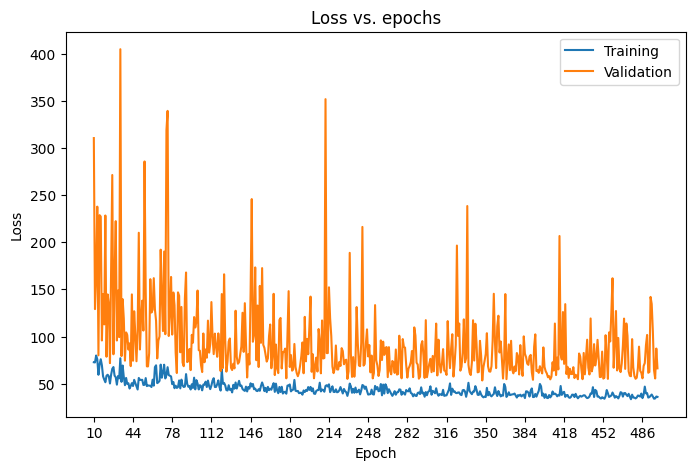

In [28]:
plot_history(history, start_epoch=10)

In [29]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


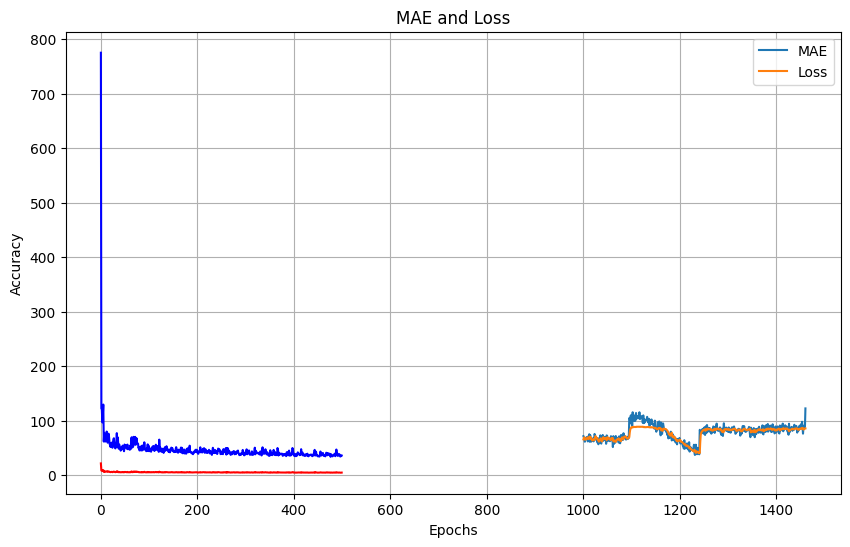

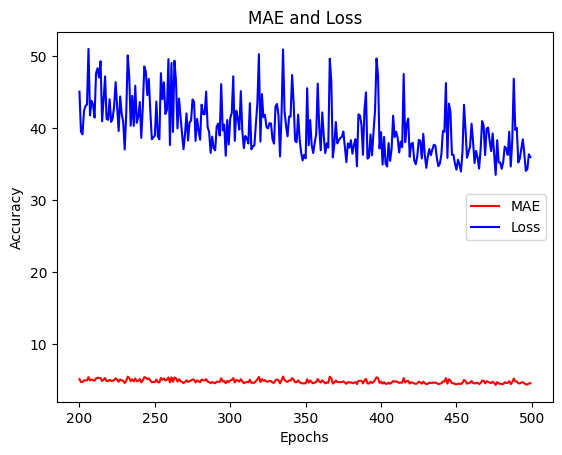

<Figure size 640x480 with 0 Axes>

In [32]:
plt.show()

In [33]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

64.38065
5.7242203


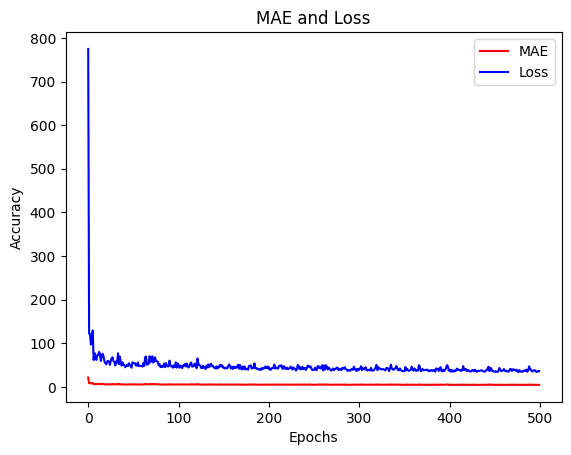

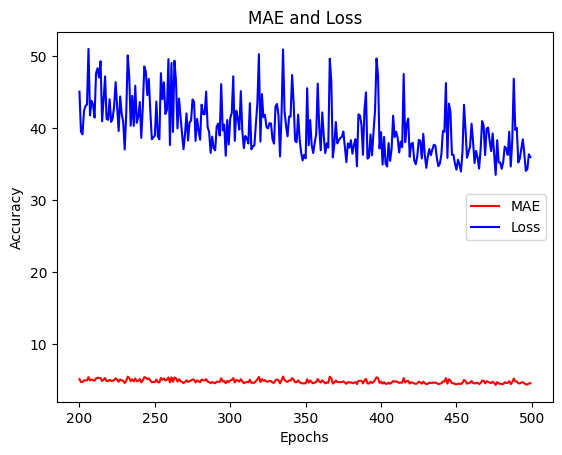

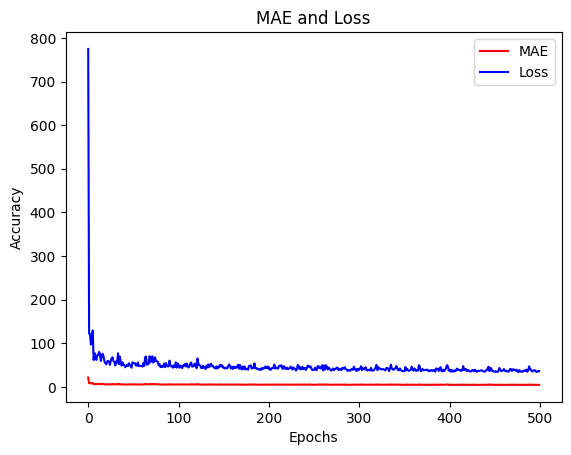

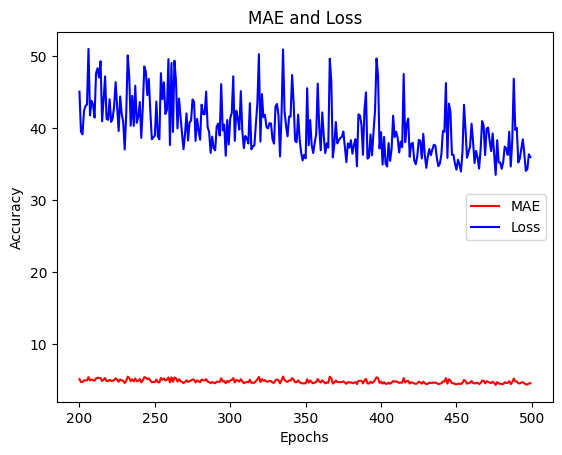

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()
plt.show()

In [37]:
# This code block will take some time to run.
# But it will run in the background, without displaying/printing 
# the information about the number of epochs.

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset, validation_data=val_set, epochs=100)

Epoch 1/100
31/31 [==============================] - 8s 65ms/step - loss: 268.3419 - val_loss: 212.9356
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 79.4713 - val_loss: 160.9218
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 70.2058 - val_loss: 180.5495
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 62.6608 - val_loss: 111.3511
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 58.8015 - val_loss: 85.8056
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 55.9574 - val_loss: 100.8319
Epoch 7/100
31/31 [==============================] - ETA: 0s - loss: 51.38 - 1s 14ms/step - loss: 50.7444 - val_loss: 135.4724
Epoch 8/100
31/31 [==============================] - 1s 13ms/step - loss: 49.7600 - val_loss: 70.3695
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 56.2980 - val_loss: 72.8875
Epoch 10/100
31/31 [==============================]

Epoch 80/100
31/31 [==============================] - 0s 12ms/step - loss: 52.2738 - val_loss: 160.6599
Epoch 81/100
31/31 [==============================] - 0s 12ms/step - loss: 50.4576 - val_loss: 58.6400
Epoch 82/100
31/31 [==============================] - 0s 12ms/step - loss: 44.5794 - val_loss: 71.2346
Epoch 83/100
31/31 [==============================] - 0s 13ms/step - loss: 43.3144 - val_loss: 85.5161
Epoch 84/100
31/31 [==============================] - 0s 13ms/step - loss: 44.4467 - val_loss: 56.3316
Epoch 85/100
31/31 [==============================] - 0s 12ms/step - loss: 44.1984 - val_loss: 92.0881
Epoch 86/100
31/31 [==============================] - 0s 12ms/step - loss: 42.5208 - val_loss: 72.8428
Epoch 87/100
31/31 [==============================] - ETA: 0s - loss: 50.98 - 0s 12ms/step - loss: 50.9841 - val_loss: 58.4380
Epoch 88/100
31/31 [==============================] - 0s 13ms/step - loss: 46.8651 - val_loss: 78.5310
Epoch 89/100
31/31 [============================

In [39]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset, validation_data=val_set, epochs=100)

Epoch 1/100
31/31 [==============================] - 13s 94ms/step - loss: 460.2571 - val_loss: 1117.6094
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 145.8594 - val_loss: 366.2450
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 89.3081 - val_loss: 163.2859
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 83.8298 - val_loss: 160.7798
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 68.6843 - val_loss: 156.8859
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 66.7631 - val_loss: 116.6895
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 61.5536 - val_loss: 101.0461
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 60.0457 - val_loss: 82.9957
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 65.9853 - val_loss: 82.4356
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - lo

31/31 [==============================] - 1s 17ms/step - loss: 48.2184 - val_loss: 68.5949
Epoch 81/100
31/31 [==============================] - 1s 17ms/step - loss: 46.1191 - val_loss: 74.1664
Epoch 82/100
31/31 [==============================] - 1s 17ms/step - loss: 47.2159 - val_loss: 61.4141
Epoch 83/100
31/31 [==============================] - 1s 17ms/step - loss: 48.9814 - val_loss: 77.2195
Epoch 84/100
31/31 [==============================] - 1s 17ms/step - loss: 45.8493 - val_loss: 84.0437
Epoch 85/100
31/31 [==============================] - 1s 18ms/step - loss: 45.4862 - val_loss: 64.5472
Epoch 86/100
31/31 [==============================] - 1s 17ms/step - loss: 46.5597 - val_loss: 64.8989
Epoch 87/100
31/31 [==============================] - 1s 19ms/step - loss: 55.4202 - val_loss: 85.9376
Epoch 88/100
31/31 [==============================] - 1s 17ms/step - loss: 45.2229 - val_loss: 65.9958
Epoch 89/100
31/31 [==============================] - 1s 17ms/step - loss: 48.2391 - v